# Tutorial

This tutorial shows the basic steps of using CyMorph to extract metrics from an image.

First we need to load `fit` image. 

In [1]:
# addtional libraries for data loading and manipulation
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10., 8.]


# image is from SDSS DR7 (objid=587725472806600764)
fits_file = fits.open('data/image.fit')
# all data arrays should be np.float32
image = np.array(fits_file[0].data, np.float32)

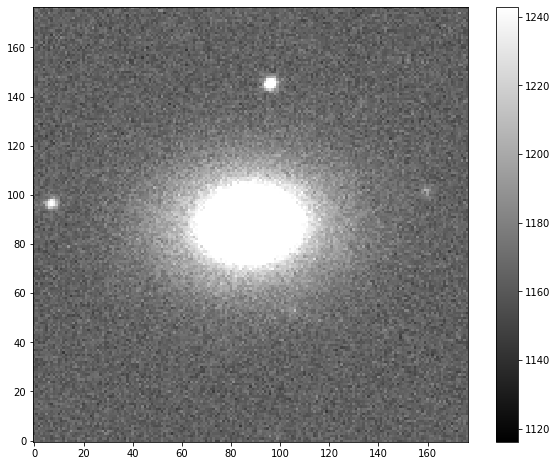

In [2]:
# show the image
m, s = np.mean(image), np.std(image)
plt.imshow(image, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();

It is important to point that image should be preprocessed:
1. Cleaned - remove secondary objects
2. Recenter - baricenter of the target object should match the central pixel of the image.
3. A segmented mask should be applied to assign 0 value for all the pixels that do not belong to the target object.

All these routines are not included in CyMorph code and is the end-user's responsibility. It is dictated by the fact that each survey is different in optics, resolution, and storage routines (sky subtraction, object identification, or even cleaning).

Here we will present basic methods to perform these steps. All steps will be heavily reling on `sep` package and its methods.

### Object detection

In [3]:
import sep
# background estimation
bkg = sep.Background(image)
# background substraction
image_sub = image - bkg
# source detection
detection_threshold = 1.5
objects, segmented_mask = sep.extract(image_sub, detection_threshold, err=bkg.globalrms, segmentation_map=True)

It is important to point that we need to pass `segmentation_map=True` to receive segmented map (mask).

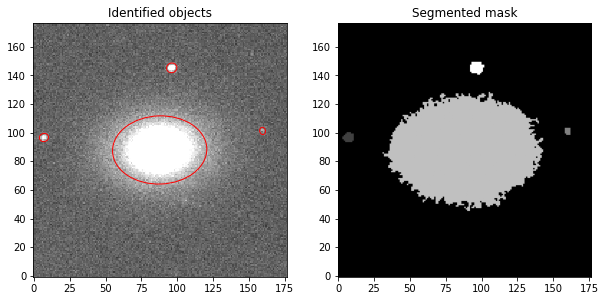

In [4]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots(1, 2)
m, s = np.mean(image_sub), np.std(image_sub)
ax[0].set_title('Identified objects')
im = ax[0].imshow(image_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=4*objects['a'][i],
                height=4*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)

# plot segmented mask for comparison
ax[1].set_title('Segmented mask')
ax[1].imshow(segmented_mask, origin='lower', cmap='gray') 

### Target object identification

Input image should contain target object in the center, so to identify it, locate the object that is the nearest to the central pixel of the image. This will yeld only the target object from array of all detected objects.

In [5]:
dx = (objects['x'] - (len(image_sub)/2))**2
dy = (objects['y'] - (len(image_sub)/2))**2
    
distance = np.sqrt(dx + dy)
# this will return only target object    
main_object = objects[distance == min(distance)]

In [6]:
# we need to find index of the target object, to identify it on the segmented mask
# each object on the segmented mask is filled with values index+1
main_object_index, = np.where(objects['x'] == main_object['x'])
main_object_index = int(main_object_index) + 1

### Clean image production

Several metrics require clean image to produce the result.

In [7]:
# clean_mask is diferent from segmented mask, is a sense that all pixels have values equal to 1
# and secondary sources have values as 0
clean_mask = np.copy(segmented_mask)

# assign 0 to main object pixels
clean_mask[clean_mask==main_object_index] = 0
# everythin that is not 0 (only pixels that belong to secondary objects) will receive 1
clean_mask[clean_mask!=0] = 1
# invert the matrix
clean_mask=1-clean_mask

In [9]:
# apply clean mask on image
clean_image = image * clean_mask

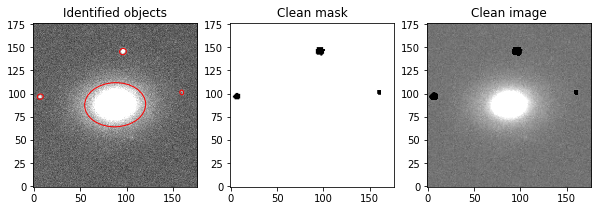

In [12]:
# plot background-subtracted image
fig, ax = plt.subplots(1, 3)
m, s = np.mean(image_sub), np.std(image_sub)
ax[0].set_title('Identified objects')
im = ax[0].imshow(image_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=4*objects['a'][i],
                height=4*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)

ax[1].set_title('Clean mask')
ax[1].imshow(clean_mask, origin='lower', cmap='gray') 

ax[2].set_title('Clean image')
m, s = np.mean(clean_image), np.std(clean_image)
ax[2].imshow(clean_image, origin='lower', cmap='gray',vmin=m-s, vmax=m+s) 

To maintaine coherence with rest of the background, it is necessary to fill these patches with matching pixel values. `sep` provides `bkg.globalback` and `bkg.globalrms`. That are a "global" mean and noise of the image background respectively.

In [13]:
# getting all the pixels belonging to secondary objects (they are all equal to 0)
x,y = np.where(clean_image==0)

# applying random values drawn from normal distribution
mu, sigma = bkg.globalback, bkg.globalrms
for key,value in enumerate(x):
    clean_image[x[key],y[key]] =  np.random.normal(mu, sigma, 1)

This will produce image with masked secondary objects and minimize the influence of the pixel variation for the metrics extraction.

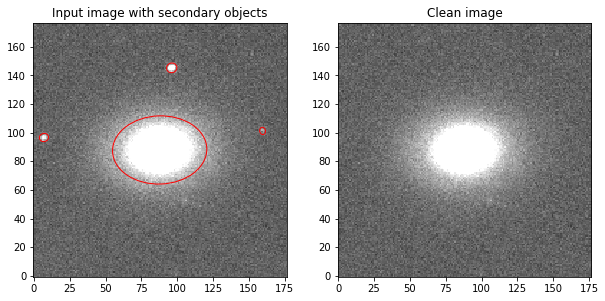

In [15]:
# plot background-subtracted image
fig, ax = plt.subplots(1, 2)
m, s = np.mean(image_sub), np.std(image_sub)
ax[0].set_title('Input image with secondary objects')
im = ax[0].imshow(image_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=4*objects['a'][i],
                height=4*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)

m, s = np.mean(clean_image), np.std(clean_image)
ax[1].set_title('Clean image')
im = ax[1].imshow(clean_image, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

### Segmenting image (isolating target object)

The diference between `clean_image` and `segented_image` is

In [ ]:
segmented_mask[segmented_mask!=main_object_index] = 0

In [ ]:
# plot background-subtracted image
fig, ax = plt.subplots(1, 2)
m, s = np.mean(image_sub), np.std(image_sub)
ax[0].set_title('Identified objects')
im = ax[0].imshow(image_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=4*objects['a'][i],
                height=4*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)

ax[1].set_title('Segmented mask')
ax[1].imshow(segmented_mask, origin='lower', cmap='gray') 

In [ ]:
segmented_image = image * segmented_mask

In [ ]:
fig, ax = plt.subplots(1, 3)
m, s = np.mean(image_sub), np.std(image_sub)
ax[0].set_title('Identified objects')
im = ax[0].imshow(image_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=4*objects['a'][i],
                height=4*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax[0].add_artist(e)

ax[1].set_title('Segmented mask')
ax[1].imshow(segmented_mask, origin='lower',cmap='gray') 

ax[2].set_title('Segmented image')
m, s = np.mean(image_sub), np.std(image_sub)
ax[2].imshow(segmented_image, interpolation='nearest', cmap='gray',
              origin='lower')

In [ ]:
clean_image = np.array(clean_image, dtype=np.float32)
segmented_image = np.array(segmented_image, dtype=np.float32)
segmented_mask = np.array(segmented_mask, dtype=np.float32)

### Concentration (C)

In [ ]:
radius1 = 0.8
radius2 = 0.2
from cymorph.concentration import Concentration
c = Concentration(clean_image, radius1, radius2) 
c.get_concentration()

### Asymmetry (A) 

In [ ]:
from cymorph.asymmetry import Asymmetry
a = Asymmetry(segmented_image) 
a.get_pearsonr(), a.get_spearmanr()

### Smoothness (S)

In [ ]:
from cymorph.smoothness import Smoothness
butterworth_order = 2
smoothing_degradation = 0.2
s = Smoothness(clean_image, segmented_mask, smoothing_degradation, butterworth_order) 
s.get_pearsonr() 
s.get_spearmanr()

### Entropy (H)

In [ ]:
from cymorph.entropy import Entropy

bins = 130
e = Entropy(image, bins) 
e.get_entropy()

### Gradient Pattern Analysis (G2)

In [ ]:
from cymorph.g2 import G2

g2_modular_tolerance               = 0.03
g2_phase_tolerance                 = 0.02

g2 = G2(segmented_image, g2_modular_tolerance, g2_phase_tolerance) 
g2.get_g2()